In [2]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
from itertools import product, cycle
from heapq import heapify, heappush, heappop
import h5py as hf
import cv2
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import networkx as nx

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.collections import PatchCollection
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase
from omnilearn import viz as viz_util

from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from src import sample_full_interventions, response_mat, factor_reponses
from src.responses import sample_full_interventions

# import gpumap
from c3linearize import linearize, class_graph

fig.get_config().silence();

In [2]:
device = 'cuda'
# device = 'cuda:1'
dataset = None
figure_root = Path('figures/responses')
figure_root = None
if figure_root is not None and not figure_root.exists():
    figure_root.mkdir()
seed = 10
B = 128
N = 16
G = 32

In [3]:
root = Path(r'C:/Users/anwan/Documents/workspace/lat_resp_models/')
# root = Path(r'C:/Users/anwan/Documents/workspace/exts/')
run_names = os.listdir(str(root))
len(run_names)

57

In [13]:
rfd_model = '''rfd_ae_e-c16_d-c16_d16-lrp00005-bs64_210514-181523	rfd_ae_e-c16_d-c16_lrp00005-bs64_210514-181523
rfd_ae_e-c16_d-s16_d16-lrp00005-bs64_210513-233108	rfd_ae_e-c16_d-s16_lrp00005-bs64_210513-233108
rfd_ae_e-c16_d-s16_d16-nosplit-lrp00005-bs64_210513-233109	rfd_ae_e-c16_d-s16_lrp00005-bs64_210513-150430
rfd_vae1_e-c16_d-c16_d16-lrp00005-bs64_210514-181523	rfd_vae1_e-c16_d-c16_lrp00005-bs64_210514-181524
rfd_vae2_e-c16_d-c16_d16-lrp00005-bs64_210514-181524	rfd_vae2_e-c16_d-c16_lrp00005-bs64_210514-181524
rfd_vae1_e-l16_d-l16_d16-lrp00005-bs64_210514-181525	rfd_vae1_e-l16_d-l16_lrp00005-bs64_210514-181523'''.replace('\t', '\n')
print(rfd_model.replace('\n', ' '))

rfd_ae_e-c16_d-c16_d16-lrp00005-bs64_210514-181523 rfd_ae_e-c16_d-c16_lrp00005-bs64_210514-181523 rfd_ae_e-c16_d-s16_d16-lrp00005-bs64_210513-233108 rfd_ae_e-c16_d-s16_lrp00005-bs64_210513-233108 rfd_ae_e-c16_d-s16_d16-nosplit-lrp00005-bs64_210513-233109 rfd_ae_e-c16_d-s16_lrp00005-bs64_210513-150430 rfd_vae1_e-c16_d-c16_d16-lrp00005-bs64_210514-181523 rfd_vae1_e-c16_d-c16_lrp00005-bs64_210514-181524 rfd_vae2_e-c16_d-c16_d16-lrp00005-bs64_210514-181524 rfd_vae2_e-c16_d-c16_lrp00005-bs64_210514-181524 rfd_vae1_e-l16_d-l16_d16-lrp00005-bs64_210514-181525 rfd_vae1_e-l16_d-l16_lrp00005-bs64_210514-181523


In [4]:
# print(tabulate(enumerate(run_names)))

In [5]:
dsname = 'celeba'
model_names = '''VAE1	celeba_vae1_e-c12_d-c12_d64-s2_210521-013413
VAE2	celeba_vae2_e-c12_d-c12_d64_210521-013413
VAE4	celeba_vae4_e-c12_d-c12_d64_210521-013413
VAE8	celeba_vae8_e-c12_d-c12_d64_210521-051200
VAE12	celeba_vae12_e-c12_d-c12_d64_210521-051200'''.split('\n')
model_names = [row.split('\t') for row in model_names]

if dataset is None:
    dataset = fig.quick_run('load-data', name='celeba', labeled=True, label_type='attr', shuffle=False, seed=seed)

In [5]:
dsname = 'toy'
dsname = 'real'
model_names = '''VAE1-6	toy_vae1_e-c12_d-c12_d6-ch128-strd-trans_210522-020221	real_vae1_e-c12_d-c12_d6-ch128-strd-trans_210522-020221
VAE1-8	toy_vae1_e-c12_d-c12_d8-ch128-strd-trans_210522-020221	real_vae1_e-c12_d-c12_d8-ch128-strd-trans_210522-020222
VAE1-10	toy_vae1_e-c12_d-c12_d10-ch128-strd-trans_210522-020222	real_vae1_e-c12_d-c12_d10-ch128-strd-trans_210522-020221
VAE1-12	toy_vae1_e-c12_d-c12_ch128-strd-trans_210522-015012	real_vae1_e-c12_d-c12_d12-ch128-strd-trans_210522-020222
VAE1-16	toy_vae1_e-c12_d-c12_d16-ch128-strd-trans_210522-020223	real_vae1_e-c12_d-c12_d16-ch128-strd-trans_210522-020222
VAE1-32	toy_vae1_e-c12_d-c12_d32-ch128-strd-trans_210522-020222	real_vae1_e-c12_d-c12_d32-ch128-strd-trans_210522-020221'''.split('\n')
model_names = [row.split('\t') for row in model_names]
if dsname == 'real':
    model_names = [[row[0], row[-1]] for row in model_names]
else:
    model_names = [[row[0], row[1]] for row in model_names]
    dsname = 'toy'

if dataset is None:
    dataset = fig.quick_run('load-data', name='mpi3d', category=dsname, mode='train', labeled=True, shuffle=False, sort=True, seed=seed)
#     dataset = fig.quick_run('load-data', name='mpi3d', category=dsname, mode='full', labeled=True, shuffle=False, sort=True, seed=seed)

In [ ]:
dsname = 'mnist'
# dsname = 'fmnist'
model_names = '''VAE1	mnist_vae1_d-conv_210517-010809	mnist_vae1_d-conv_fashion_210517-111436
VAE1-s2	mnist_vae1_d-conv_s2_210523-154655	mnist_vae1_d-conv_fashion-s2_210523-154656
VAE1-s3	mnist_vae1_d-conv_s3_210523-154656	mnist_vae1_d-conv_fashion-s3_210523-154656
VAE2	mnist_vae2_d-conv_210517-010809	mnist_vae2_d-conv_fashion_210517-111436
VAE2-s2	mnist_vae2_d-conv_s2_210523-154655	mnist_vae2_d-conv_fashion-s2_210523-154656
VAE2-s3	mnist_vae2_d-conv_s3_210523-154656	mnist_vae2_d-conv_fashion-s3_210523-154656
VAE4	mnist_vae4_d-conv_210517-011708	mnist_vae4_d-conv_fashion_210523-154656
VAE4-s2	mnist_vae4_d-conv_s2_210523-154656	mnist_vae4_d-conv_fashion-s2_210523-154656
VAE4-s3	mnist_vae4_d-conv_s3_210523-154656	mnist_vae4_d-conv_fashion-s3_210523-154655
VAE8	mnist_vae8_d-conv_210517-011730	mnist_vae8_d-conv_fashion_210523-154656
VAE8-s2	mnist_vae8_d-conv_s2_210523-154657	mnist_vae8_d-conv_fashion-s2_210523-154656
VAE8-s3	mnist_vae8_d-conv_s3_210523-154658	mnist_vae8_d-conv_fashion-s3_210523-154656'''.split('\n')
model_names = [row.split('\t') for row in model_names]
if dsname == 'fmnist':
    model_names = [[row[0], row[-1]] for row in model_names]
else:
    model_names = [[row[0], row[1]] for row in model_names]
    dsname = 'mnist'
    
if dataset is None:
    dataset = fig.quick_run('load-data', name=dsname, mode='full', labeled=True, shuffle=False, seed=seed)

In [5]:
dsname = '3ds12'
# dsname = '3ds24'
model_names = '''VAE1	3ds_vae1_d-conv_s1_210523-164722	3ds_vae1_d-conv_d24-s1_210523-164723
VAE1-s2	3ds_vae1_d-conv_s2_210523-164723	3ds_vae1_d-conv_d24-s2_210523-164722
VAE2	3ds_vae2_d-conv_s1_210523-164723	3ds_vae2_d-conv_d24-s1_210523-164722
VAE2-s2	3ds_vae2_d-conv_s2_210523-164722	3ds_vae2_d-conv_d24-s2_210523-164722
VAE4	3ds_vae4_d-conv_s1_210523-164723	3ds_vae4_d-conv_d24-s1_210523-164722
VAE4-s2	3ds_vae4_d-conv_s2_210523-164722	3ds_vae4_d-conv_d24-s2_210523-164722
VAE8	3ds_vae8_d-conv_s1_210523-164722	3ds_vae8_d-conv_d24-s1_210523-164723
VAE8-s2	3ds_vae8_d-conv_s2_210523-164722	3ds_vae8_d-conv_d24-s2_210523-164722'''.split('\n')
model_names = [row.split('\t') for row in model_names]
if dsname == '3ds24':
    model_names = [[row[0], row[-1]] for row in model_names]
else:
    model_names = [[row[0], row[1]] for row in model_names]
    dsname = '3ds12'

if dataset is None:
    dataset = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False, seed=seed)

In [6]:
batch = dataset.get_batch(shuffle=True)
X, Y = batch
X.shape, Y.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 7]))

In [7]:
# util.plot_imgs(X);

In [8]:
# sampler, interventions = None, None
# if dsname in {'3ds12', '3ds24', 'toy', 'real'}:
#     factors = dataset.get_factor_order()
#     factor_sizes = dataset.get_factor_sizes()
#     print(factors, factor_sizes)
#     sampler = InterventionSamplerBase(dataset)
#     interventions = sample_full_interventions(sampler, num_groups=20, pbar=tqdm)
#     intervention_dim = 0
#     intervention_imgs = sampler.full_intervention(intervention_dim)
#     imgs = intervention_imgs
#     util.plot_imgs(imgs);

In [9]:
runs = [fig.quick_run('load-run', path=row[-1], root=str(root), **{'override.device':'cpu'}) for row in model_names]

ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"


In [10]:
print(tabulate([[i,*row] for i,row in enumerate(model_names)], headers=['Idx', 'Model', 'Run']))

  Idx  Model    Run
-----  -------  --------------------------------------------------------
    0  VAE1-6   real_vae1_e-c12_d-c12_d6-ch128-strd-trans_210522-020221
    1  VAE1-8   real_vae1_e-c12_d-c12_d8-ch128-strd-trans_210522-020222
    2  VAE1-10  real_vae1_e-c12_d-c12_d10-ch128-strd-trans_210522-020221
    3  VAE1-12  real_vae1_e-c12_d-c12_d12-ch128-strd-trans_210522-020222
    4  VAE1-16  real_vae1_e-c12_d-c12_d16-ch128-strd-trans_210522-020222
    5  VAE1-32  real_vae1_e-c12_d-c12_d32-ch128-strd-trans_210522-020221


In [11]:
run = runs[2]
run

INLINE_TIMED_SAE_RUN:real_vae1_e-c12_d-c12_d10-ch128-strd-trans_210522-020221

In [12]:
A = run.get_config()
info = A.pull('info')
info

{'arch_type': 'c12',
 'dataset_type': 'real',
 'dec_type': 'c12',
 'enc_type': 'c12',
 'extra': 'd10-ch128-strd-trans',
 'model_type': 'vae',
 'size': 64}

In [13]:
if figure_root is not None:
    figure_dir = figure_root / run_name
    if not figure_dir.exists():
        figure_dir.mkdir()
else:
    figure_dir = None
model = run.get_model()
model.switch_to('val')
model.to(device);
def ae_cycle(q):
    im = model.decode(q.to(device))
    q = model.encode(im)
    if isinstance(q, distrib.Normal):
        q = q.loc
    return im.cpu(), q.cpu()
def encode(x):
    with torch.no_grad():
        q = model.encode(x.to(device))
        if isinstance(q, distrib.Normal):
            q = q.loc
    return q
def decode(q):
    with torch.no_grad():
        return model.decode(q.to(device))

VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): ELU(alph

In [14]:
figure_dir

In [15]:
stretch = 0.1
pt_num = 200

In [16]:
Qdis = None
with torch.no_grad():
    Q = model.encode(X.to(device))
    if isinstance(Q, distrib.Normal):
        Qdis = Q
        Q = Q.mean
    Q = Q.cpu()

rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
Q.shape

torch.Size([64, 10])

In [17]:
# util.plot_imgs(X[:16]);
# util.plot_imgs(decode(Q[:16]));

In [18]:
bidx = 0

q = Q[bidx]
Q.shape, q.shape

(torch.Size([64, 10]), torch.Size([10]))

In [19]:
fullQ = []
total = 10000
bs = 100
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
D = fullQ.size(-1)
fullQ.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 10])

In [20]:
scales = fullQ.std(0)
# scales = None

<IPython.core.display.Javascript object>


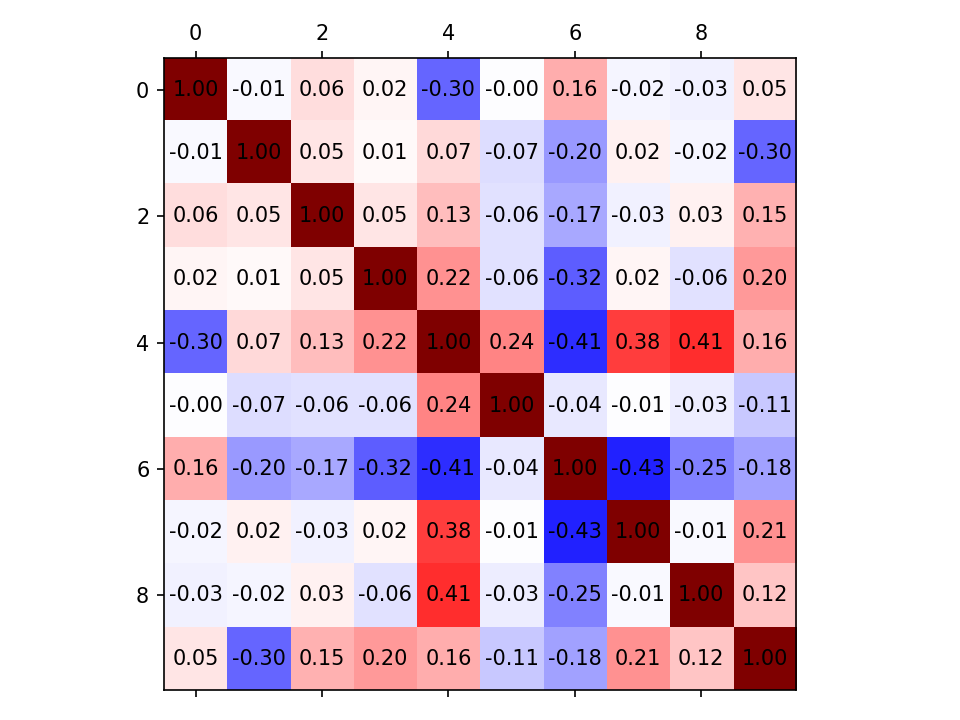

In [21]:
C = np.cov(fullQ.div(scales).cpu().t().numpy())
# util.plot_mat(C, cmap='seismic', vmin=-1, vmax=1)
util.plot_mat(C, val_fmt=2, cmap='seismic', vmin=-1, vmax=1)
plt.tight_layout()
# util.save_figure(f'{run_name}_cov', root=figure_dir)
util.save_figure(f'cov', root=figure_dir)

In [22]:
N = 400
R = response_mat(fullQ[:N], model.encode, model.decode, scales=scales, dist_type='rms', force_different=True)

In [23]:
threshold = 0.5
threshold_2d = 0.1

In [24]:
sel = torch.arange(len(R))[R.diag() > threshold]
bsel = torch.arange(len(R))[R.diag() <= threshold]
sel, bsel

(tensor([0, 1, 2, 3, 5, 7, 8]), tensor([4, 6, 9]))

<IPython.core.display.Javascript object>


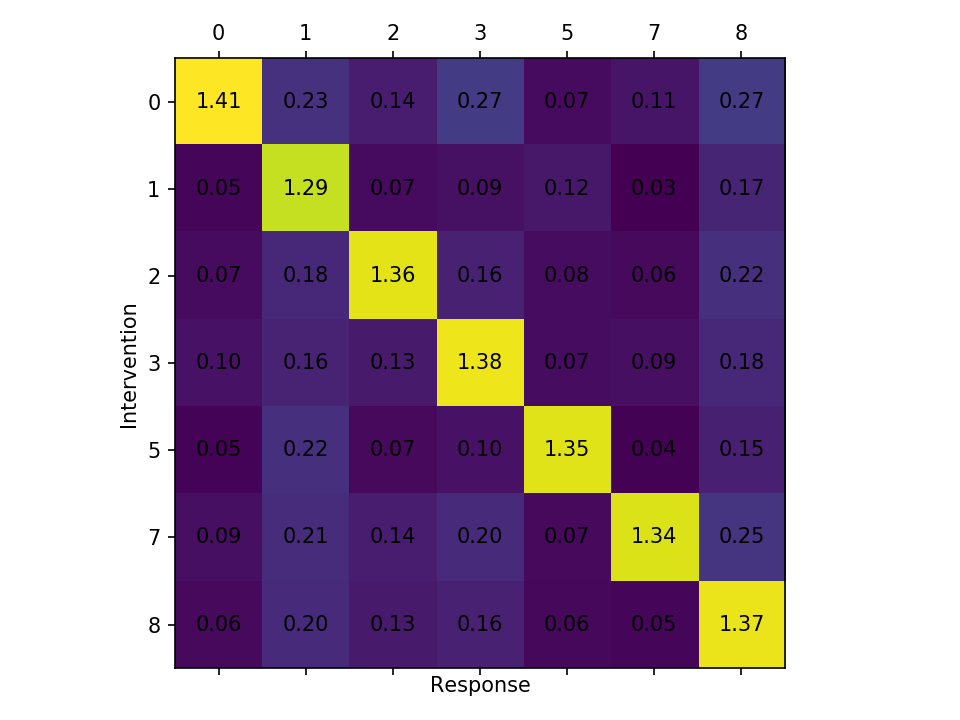

In [25]:
Rsel = R[sel][:,sel]
hside = 0.4
util.plot_mat(Rsel, val_fmt=2, )#figsize=(len(Rsel)*hside, hside*len(Rsel))) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout()
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)
# util.save_figure(f'sel_responses', root=figure_dir)

In [81]:
# G = nx.from_numpy_matrix(R[sel][:,sel].cpu().pow(1.5).numpy(), create_using=nx.MultiDiGraph)

# colors = 'C2'
# # colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

# edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

# try:
#     pos = nx.planar_layout(G)
# except:
# #     pos = nx.spring_layout(G)
#     pos = nx.circular_layout(G)

# kwargs = dict(pos=pos, node_color=colors, labels={i:str(n.item()) for i,n in enumerate(sel)},#, with_labels=True,
#               edgelist=edges, edge_color=weights,
#               edge_cmap=plt.get_cmap('binary'), vmin=0)
# plt.figure()
# nx.draw(G, **kwargs)
# # util.save_figure(f'{run_name}_graph', root=figure_dir)
# util.save_figure(f'sel-graph', root=figure_dir)

In [312]:
mats, lts = factor_reponses(encode, decode, interventions, pbar=tqdm, include_q=True, 
                       resp_kwargs=dict(scales=scales,force_different=True))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


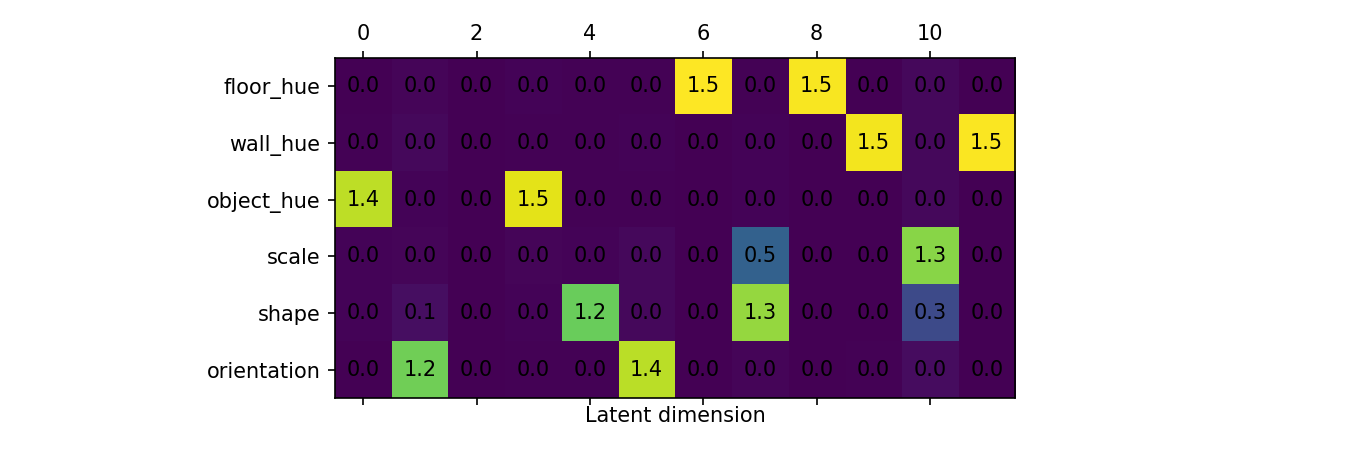

In [313]:
M_old = mats.min(1)[0].max(-1)[0]
M = mats.min(1)[0].diagonal(0,-1,-2)
M = mats.mean(1).diagonal(0,-1,-2)
# M = mats.max(1)[0].diagonal(0,-1,-2)
# M = mats.mean(1).max(-1)[0]

# mats.shape, len(lts), M.shape

util.plot_mat(M, val_fmt=1, figsize=(9,3))
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
# util.save_figure(f'factor-responses', root=figure_dir);

In [26]:
resp = R.cpu()[sel][:,sel]
D = resp.size(-1)
resp.shape

torch.Size([7, 7])

In [27]:
scores = resp + resp.t()
scores -= scores.diag().diag()
relscores = scores.div(scores.sum(-1,keepdim=True))
# util.plot_mat(relscores, val_fmt=2);
# plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
# plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
# plt.tight_layout();

In [28]:
def collect_pairs(scores, inds, temp=1.):
    while len(inds) >= 2:
        pick = torch.stack(torch.meshgrid(torch.arange(len(inds)),torch.arange(len(inds)),),-1).reshape(-1,2).tolist()[np.random.choice(np.arange(len(inds)**2), p=F.normalize(scores.reshape(-1).pow(1/temp),p=1,dim=0).numpy())]
        yield (inds[pick].tolist(), scores[tuple(pick)].item())
        sel = torch.ones(len(inds)).bool()
        sel[pick] = 0
        scores, inds = scores[sel][:,sel], inds[sel]
    if len(inds):
        yield inds.item()
    else:
        yield None
    yield None
*picks, remainder, _ = list(collect_pairs(scores.clone(), sel.clone(), temp=0.2))
pairs, sc_picks = zip(*picks)
print(remainder, pairs, sc_picks)

2 ([3, 7], [8, 0], [5, 1]) (0.2921085059642792, 0.3327900767326355, 0.3411611020565033)


In [29]:
def _gen_se2_inds(i,j):
    return [(i,i), (i,j), (i,D), (j,i), (j,j), (j,D)]

def gen_inds(*idx, dims=2):
    return list(product(*[idx]*dims))


In [32]:
dims = pairs[np.random.choice(len(pairs))]
# dims = pairs[0]

dims, sc = next(iter(collect_pairs(relscores.clone(), sel.clone(), temp=0.2)))

# dims = 1,4

ix, iy = dims
dims = list(dims)
dims, sc

([0, 3], 0.24818794429302216)

In [33]:
Qsel = Q[:,dims]
pt = Qsel.sub(Qsel.mean(0,keepdim=True))
# plt.figure()
# plt.scatter(*pts.t(), marker='.', c='k');
U, S, V = torch.svd(pt.t() @ pt / (len(pt) - 1))
S = S.sqrt()
print('S',S)
print(U)
Q.shape, Qsel.shape

S tensor([0.7989, 0.7656])
tensor([[-0.6183,  0.7859],
        [ 0.7859,  0.6183]])


(torch.Size([64, 10]), torch.Size([64, 2]))

In [34]:
vec = fullQ[N:N+pt_num].detach().cpu()
pts = vec[:,dims]
mu = pts.mean(0)
pt = pts.sub(pts.mean(0,keepdim=True))
U, S, V = torch.svd(pt.t() @ pt / (B - 1))
S = S.sqrt()
# plt.figure()
# plt.scatter(*pts.t(), marker='.', c='k');
# plt.axis('equal');
# plt.grid(b=True, which='both', color='0.65', linestyle='--')
# ars = torch.stack([mu, mu+S[0]*U[0]])
# plt.plot(*ars.t());
# ars = torch.stack([mu, mu+S[1]*U[1]])
# plt.plot(*ars.t());
se2 = util.aff_invert(util.se2_tfm(U, mu.unsqueeze(1)))
fixed = util.aff_transform(pts, se2)
# plt.scatter(*fixed.t(), marker='x', c='r');

In [35]:
# plt.figure()
# plt.plot(options,scores);

In [36]:
stretch = .2
rg = 2

mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
mn, mx = mn.view(-1), mx.view(-1)

print(mn[list(dims)], mx[list(dims)])

mn, mx = torch.ones(len(mn))*-rg, torch.ones(len(mx))*rg

tensor([-2.6479, -1.8008]) tensor([2.4482, 2.0762])


In [37]:
n = 100
h, w = n, n

xvals, yvals = torch.linspace(mn[ix].item(),mx[ix].item(),h), torch.linspace(mn[iy].item(),mx[iy].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = Q[bidx:bidx+1].expand(len(cx), -1).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy

starts = vecs[...,dims]
ends = []
for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=100), desc=f'Cycling {len(vecs)} samples'):
    with torch.no_grad():
        ends.append(ae_cycle(v)[1][...,dims])
starts = starts.view(h,w,2)
ends = torch.cat(ends).view(h,w,2)
gradmap = ends.sub(starts)
gradmap.shape

Cycling 10000 samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 100, 2])

In [38]:
def get_divergence(vmap):
    divx, divy = np.gradient(vmap, axis=[0,1])
    divM = divx[...,0] + divy[...,1]
    return torch.from_numpy(divM)

magmap = gradmap.norm(dim=-1)
divmap = get_divergence(gradmap)
sdivmap = divmap.clone()
if sdivmap.min() < 0:
    sdivmap[sdivmap<0] /= sdivmap.min().abs()
else:
    print('WARNING: min')
if sdivmap.max() > 0:
    sdivmap[sdivmap>0] /= sdivmap.max().abs()
else:
    print('WARNING: max')

curvmap = -0.5*get_divergence(gradmap.div(magmap.unsqueeze(-1)))
happymap = divmap<0

<IPython.core.display.Javascript object>


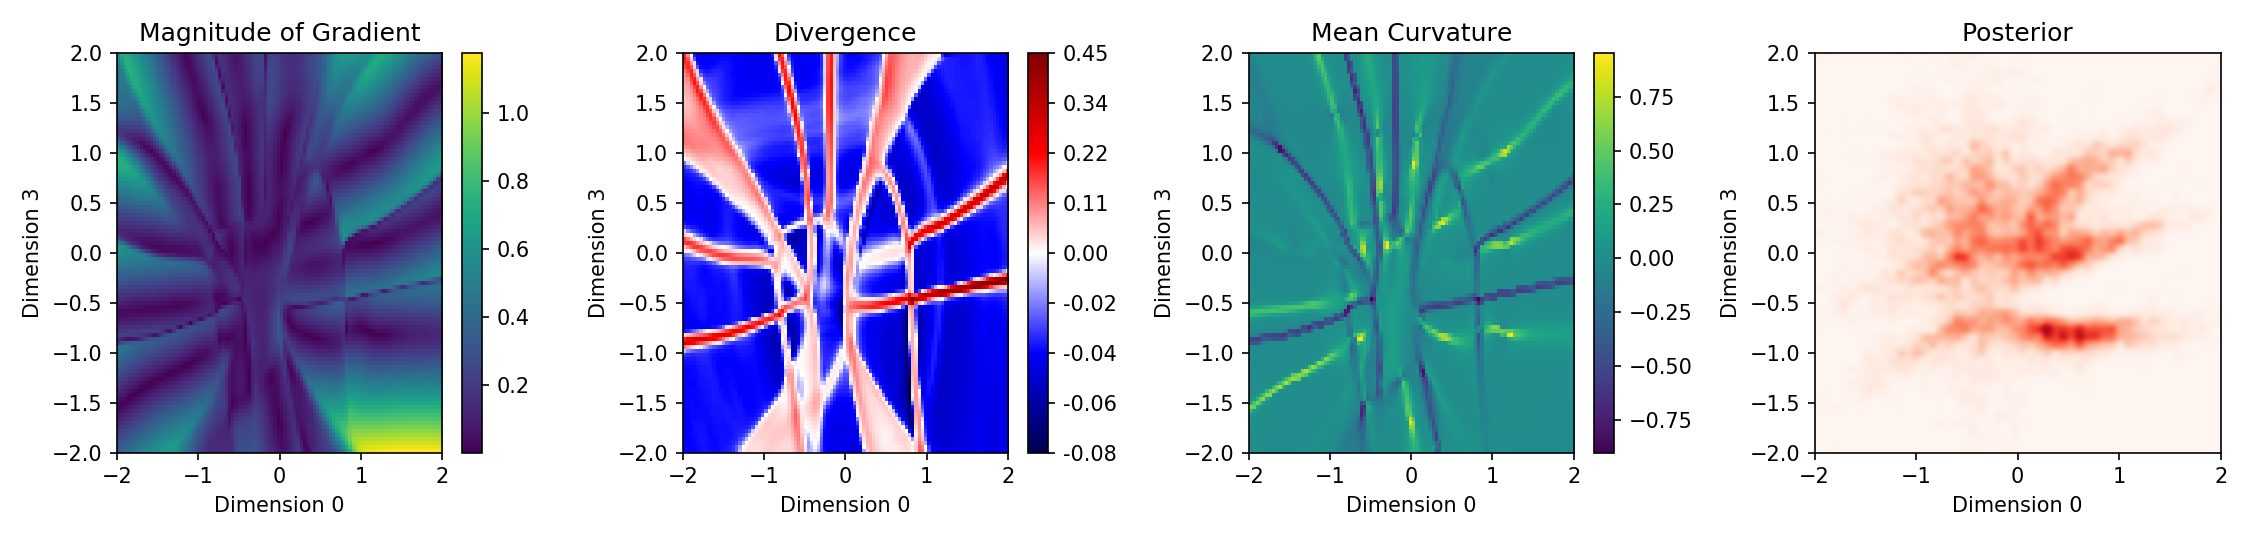

In [39]:
im_kwargs = dict(
    aspect = 'auto',
    extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()],
)

fg, axs = plt.subplots(1,4, figsize=(15,3.6))

plt.sca(axs[0])
plt.title('Magnitude of Gradient')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(magmap.numpy().T[::-1], cmap='viridis', **im_kwargs);
plt.colorbar()

plt.sca(axs[1])
plt.title('Divergence')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(sdivmap.numpy().T[::-1], cmap='seismic', **im_kwargs);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divmap.min().item(), 0,5), np.linspace(0,divmap.max().item(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)

plt.sca(axs[2])
plt.title('Mean Curvature')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(curvmap.numpy().T[::-1], cmap='viridis', **im_kwargs);
plt.colorbar()

plt.sca(axs[3])
plt.title('Posterior')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max())
hist, *other = np.histogram2d(*fullQ[:,dims].t().cpu().numpy(), bins=n//2, normed=True, range=torch.stack([mn[dims],mx[dims]]).t().cpu().numpy())
plt.imshow(hist.T[::-1], cmap='Reds', interpolation = "gaussian", **im_kwargs)
# sns.kdeplot(*Q.t().cpu().numpy(), shade=True, ax=axs[3], gridsize=200, thresh=0.01)
badsel = np.ones((*happymap.shape,4))
badsel[...,-1] = 0.
badsel[~happymap.numpy().T[::-1]] = [1,0,0,1]
# plt.imshow(badsel, alpha=0.3, **im_kwargs)
# plt.imshow(mags);
plt.tight_layout()


In [40]:
def cdf(x):
    return x.div(np.sqrt(2)).erf().add(1).div(2)
dx = xvals[1]-xvals[0]
xedges = torch.linspace(xvals[0]-dx/2,xvals[-1]+dx/2,w+1)
dy = yvals[1]-yvals[0]
yedges = torch.linspace(yvals[0]-dy/2,yvals[-1]+dy/2,h+1)
xcdf = cdf(xedges)
xprob = xcdf[1:] - xcdf[:-1]
ycdf = cdf(yedges)
yprob = ycdf[1:] - ycdf[:-1]
xyprob = torch.stack(torch.meshgrid(xprob, yprob)).prod(0)
xyprob.sum(), xyprob[~happymap].sum(), xyprob[~happymap].sum().div(xyprob.sum())

(tensor(0.9152), tensor(0.2825), tensor(0.3087))

<IPython.core.display.Javascript object>


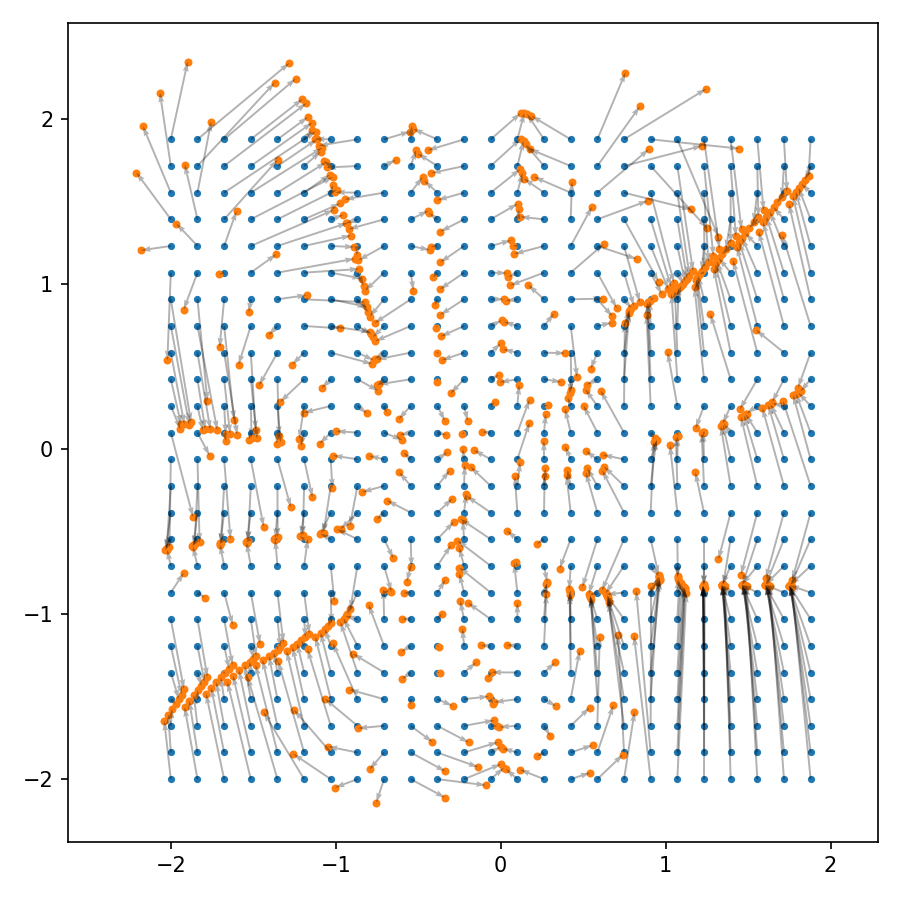

In [41]:
stepn = 4
s = starts[::stepn,::stepn,].reshape(-1,2)
e = ends[::stepn,::stepn].reshape(-1,2)
d = gradmap[::stepn,::stepn].reshape(-1,2)

plt.figure(figsize=(6,6))
plt.scatter(*s.t(), s=6)
plt.scatter(*e.t(), s=8)
plt.quiver(*s.t(), *d.view(-1,2).t(), angles='xy', scale_units='xy', scale=1, lw=0.2, alpha=0.3)
plt.xlim(starts[...,0].min()*1.1, starts[...,0].max()*1.1)
plt.ylim(starts[...,1].min()*1.1, starts[...,1].max()*1.1)
plt.axis('equal')
plt.tight_layout();

<IPython.core.display.Javascript object>


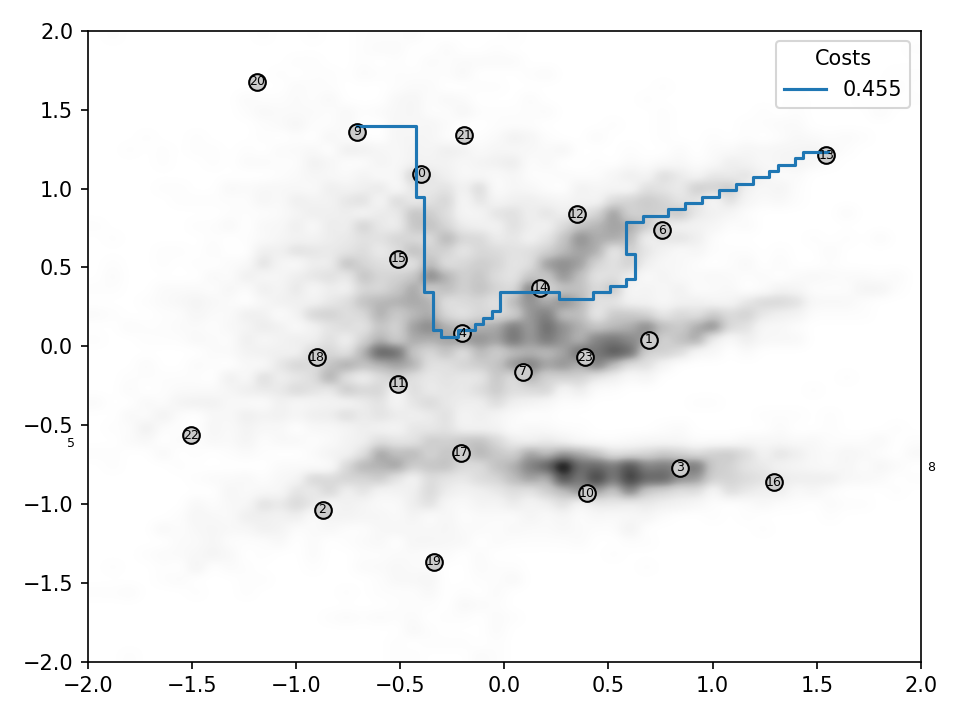

In [93]:
plt.figure()
ax_lat_path = plt.gca()
plt.imshow(hist.T[::-1], cmap='Greys', interpolation = "gaussian", **im_kwargs)
# plt.imshow(curvmap.numpy().T[::-1], cmap='viridis', **im_kwargs);

n_cts = 24

cts = torch.from_numpy(KMeans(n_clusters=n_cts, random_state=10).fit(Qsel.numpy()).cluster_centers_)
xinds = torch.searchsorted(xvals, cts[:,0].contiguous())
yinds = torch.searchsorted(yvals, cts[:,1].contiguous())
cinds = torch.stack([xinds,yinds],-1)
cinds = [tuple(c) for c in cinds.tolist()]

for k, q in enumerate(cts):
    plt.plot(*q, 'o', markerfacecolor='0.8',
             markeredgecolor='k', markersize=8)
    plt.text(*q, str(k), ha='center', va='center', fontsize=6)
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max());
plt.tight_layout();

In [94]:
path_cts = [
    [13,9],
]
all_paths = []
all_costs = []

temp = 1./2

In [95]:
landscape = magmap.clone()**(1/temp)
posteriormap = curvmap.clone()
landscape.shape

torch.Size([100, 100])

In [96]:
DMAP = nx.grid_2d_graph(*magmap.shape)
# def _cost(u,v,*other):
# #     print(u,v,other)
# #     dr = torch.tensor([v[0]-u[0], v[1]-u[1]]).float().cpu()
# #     return (dr @ deltas[u]).item()
#     return mags[v]
def _find_route(u,v):
    L, ph = nx.algorithms.shortest_paths.weighted.single_source_dijkstra(DMAP, cinds[u], cinds[v], weight=lambda u,v,_o: landscape[v].item())
    return L, (u,v), ph

for s,e in path_cts:
    cost, _, path = _find_route(s,e)

    xlp, ylp = zip(*path)
    xlp, ylp = xvals[list(xlp)], yvals[list(ylp)]
    Qpath = torch.stack([xlp, ylp],-1)
    all_costs.append(cost)
    all_paths.append(Qpath)
# plt.plot(xlp, ylp, c='m');
# cost, len(path)
plt.sca(ax_lat_path)
for i, (path, cost) in enumerate(zip(all_paths, all_costs)):
    plt.plot(*path.t(), c=f'C{i}',label=f'{cost:.3g}')
plt.legend(title='Costs');

all_costs

[0.45525278069453634]

In [97]:
show_mov = False
show_interp = np.random.randint(len(all_paths))
show_interp

0

In [98]:
def _show_interp(frames, vid=True):
    if vid:
        plt.ioff()
        mov = util.Video(frames.permute(0,2,3,1).cpu())
        if figure_dir is not None:
            path = figure_dir / f'seq{bidx}.mp4'
        #     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
            mov.export(path)
            print(f'Movie saved: {str(path)}')
        out = mov.play('jupyter', scale=4)
        plt.ion()
    else:
        hval = 1
        util.plot_imgs(frames, W=len(interp), figsize=(len(interp)*hval,hval));
        s = 0.01
        plt.subplots_adjust(bottom=0.+s, top=1.-s, left=0.+s, right=1.-s, wspace=s, hspace=s)
        out = None
    return out

In [129]:
show_vid = True
nframes = 60 if show_vid else 7

bidx = 20

xlp, ylp = all_paths[show_interp].t()

xvp, yvp = torch.linspace(xlp[0],xlp[-1],nframes), torch.linspace(ylp[0],ylp[-1],nframes)
vecs = Q[bidx:bidx+1].expand(len(xvp), -1).contiguous()
vecs[...,dims[0]] = xvp
vecs[...,dims[1]] = yvp

binterp = decode(vecs)

xpin, ypin = torch.linspace(0,len(xlp)-1,nframes).long(), torch.linspace(0,len(ylp)-1,nframes).long()
xvp, yvp = xlp[xpin], ylp[ypin]
vecs = Q[bidx:bidx+1].expand(len(xvp), -1).contiguous()
vecs[...,dims[0]] = xvp
vecs[...,dims[1]] = yvp

interp = decode(vecs)
display(_show_interp(binterp, vid=show_vid))
display(_show_interp(interp, vid=show_vid))

In [139]:
fid_dim = 2048
true_mu, true_std = dataset.get_fid_stats(fid_dim, 'train')
true_mu, true_std = torch.from_numpy(true_mu), torch.from_numpy(true_std)
inception = learn.eval.fid.load_inception_model(fid_dim)
dr = distrib.MultivariateNormal(true_mu, true_std)
def _score(samples):
    feats = learn.eval.fid.apply_inception(samples, inception).squeeze().cpu()
    return dr.log_prob(feats)
# true_mu.shape, true_std.shape

In [140]:
_score(binterp).mean()

tensor(1613.5855, dtype=torch.float64)

In [141]:
_score(interp).mean()

tensor(2059.9514, dtype=torch.float64)

In [ ]:
fid_stats[:1]

In [ ]:
learn.eval.fid.compute_frechet_distance(*, *true_stats)

In [ ]:
fid_stats

In [541]:
n = 16
steps = 40
# info.steps = 20
# info.steps = 7
# info.steps = 5
ntrav = 1

In [542]:
q = Q[bidx]

tH, tW = 4,3
if info is None:
    tH, tW = 5, 2
else:
    if info['dec_type'] == 's6':
        tH, tW = 6,2
    if info['dec_type'] == 's3':
        tH, tW = 3,4

vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=steps,
      mnmx=(mn,mx)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode, device=device).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape
    
if walks.size(1) != tH*tW:
    tH, tW = util.calc_tiling(walks.size(1))
    
tH, tW

(4, 3)

In [543]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, tH, tW, S, C, H, W)
# print(full.shape)
full = full.squeeze(0).permute(2,0,4,1,5,3).contiguous()
frames = full.view(S, tH*H, tW*W, C).mul(255).byte().numpy()



frames.shape
# full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

(40, 256, 192, 3)

In [544]:

font                   = cv2.FONT_HERSHEY_SIMPLEX
font                   = cv2.FONT_HERSHEY_COMPLEX
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 1

px, py = 2, 12

for frame in frames:
    for i,j in np.ndindex(tH, tW):
        idx = i*tW+j
        cv2.putText(frame, f'{idx}', 
            (px+H*j, py+W*i), 
            font, 
            fontScale,
            fontColor,
            lineType)


In [545]:
mov = util.Video(frames)
if figure_dir is not None:
    path = figure_dir / f'seq{bidx}.mp4'
#     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
    mov.export(path)
    print(f'Movie saved: {str(path)}')
plt.ioff()
out = mov.play('jupyter', scale=2)
plt.ion()
out

<IPython.core.display.Javascript object>


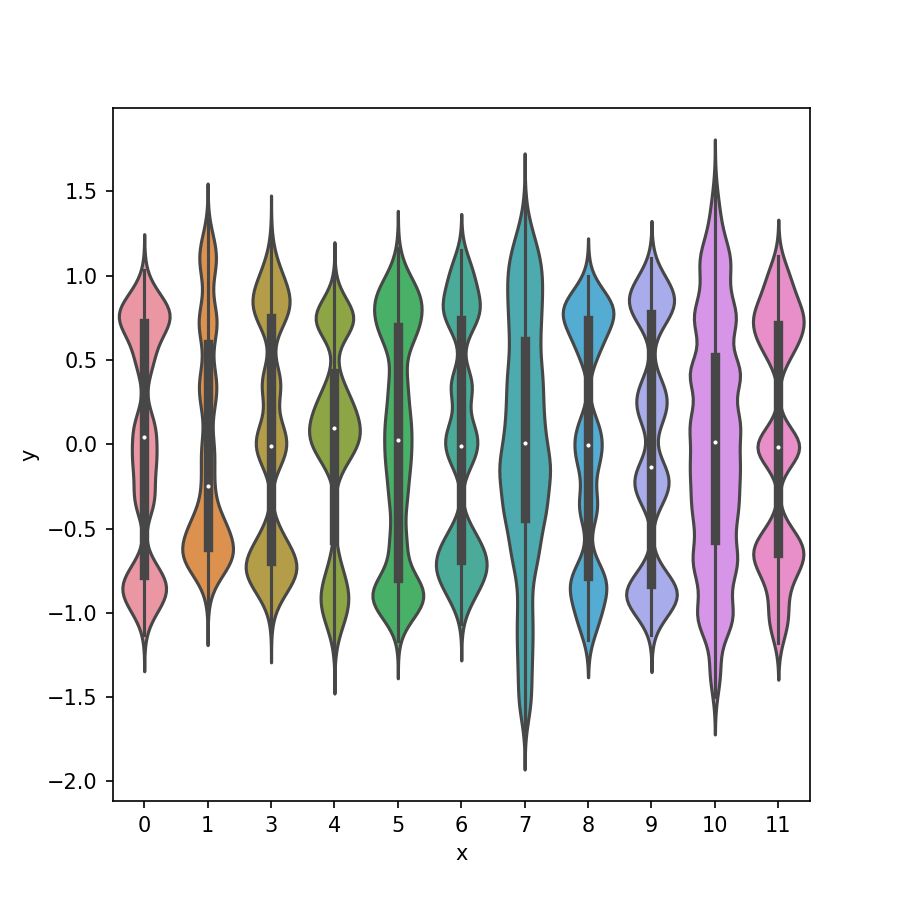

In [546]:
util.plot_distribs(fullQ.t()[sel].cpu());
plt.xticks(np.arange(len(sel)),sel.tolist());
util.save_figure(f'latent_marginals', root=figure_dir);

<IPython.core.display.Javascript object>


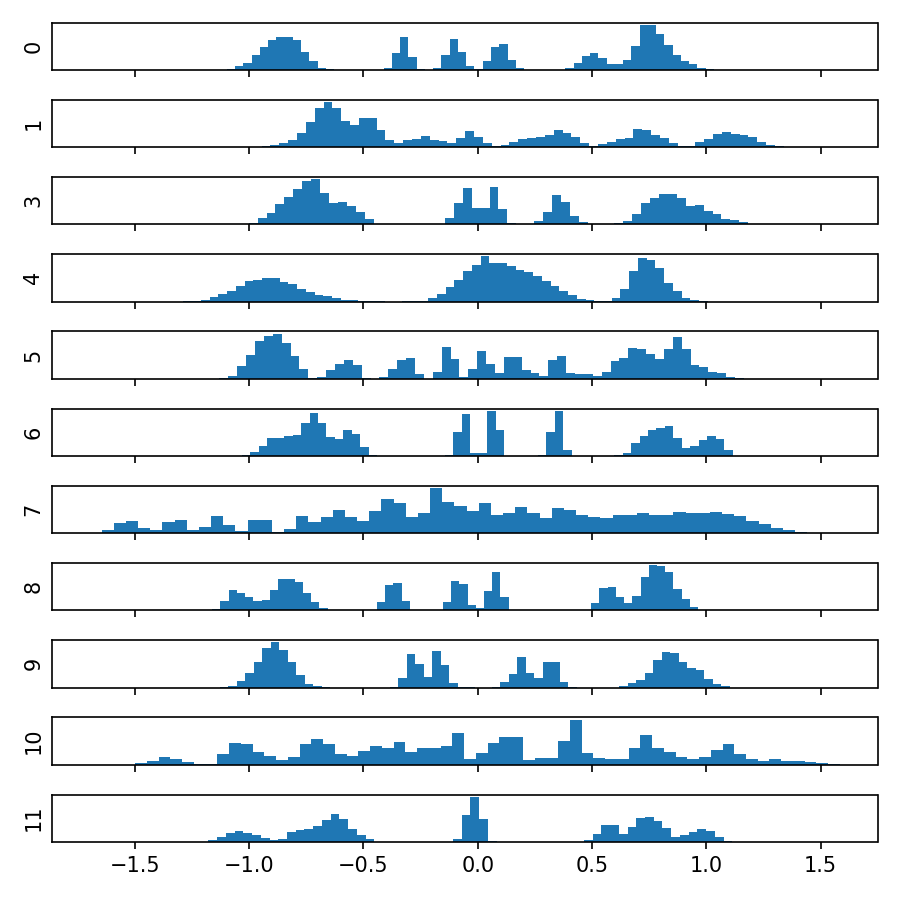

In [547]:
pts = fullQ.cpu().t()[sel]
fg, axs = util.plot_hists(pts, bins=60, sharex=True);
for ax, s in zip(axs, sel.tolist()):
    plt.sca(ax)
    plt.ylabel(str(s))
#     plt.xticks([])
    plt.yticks([])
plt.tight_layout()
util.save_figure(f'latent_hists', root=figure_dir);